In [373]:
import os
import sys
import glob
import scipy
import matplotlib
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from shutil import copyfile
import scipy.stats

from tqdm import tqdm

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

plt.rcParams['svg.fonttype'] = 'none'
import shutil
from IPython.display import display, HTML

from Bio import SeqIO

# Load wastewater SNVs

In [386]:
WSdb = pd.read_csv('../final_tables/Wastewater_SNVs_v3.csv')
for c in ['key']:
    WSdb[c] = [eval(x) for x in WSdb[c]]

## fix sample names
new_sample = []
for index, row in WSdb.iterrows():
    new_sample.append(row['sample'].split("-")[0])
WSdb['sample'] = new_sample
Adb = pd.read_csv('../final_tables/Wastewater_abundance_v2.csv')
WSdb['coverage'] = WSdb['sample'].map(Adb.set_index('sample')['coverage'].to_dict())
    
WSdb

,scaffold,position,position_coverage,allele_count,ref_base,con_base,var_base,ref_freq,con_freq,var_freq,A,C,T,G,cryptic,class,sample,key,key_freq,coverage
0,hCoV-19_Wuhan_WIV04_2019_EPI_ISL_402124_2019-1...,240,12,1,C,T,A,0.000000,1.000000,0.000000,0,0,12,0,False,SNS,5_28_S,"(240, T)",1.000000,8.407775
1,hCoV-19_Wuhan_WIV04_2019_EPI_ISL_402124_2019-1...,1569,11,2,T,T,C,0.818182,0.818182,0.181818,0,2,9,0,False,SNV,5_28_S,"(1569, C)",0.181818,8.407775
2,hCoV-19_Wuhan_WIV04_2019_EPI_ISL_402124_2019-1...,2188,10,2,C,C,T,0.800000,0.800000,0.200000,0,8,2,0,False,SNV,5_28_S,"(2188, T)",0.200000,8.407775
3,hCoV-19_Wuhan_WIV04_2019_EPI_ISL_402124_2019-1...,2190,11,2,T,T,C,0.818182,0.818182,0.181818,0,2,9,0,False,SNV,5_28_S,"(2190, C)",0.181818,8.407775
4,hCoV-19_Wuhan_WIV04_2019_EPI_ISL_402124_2019-1...,2192,10,2,G,G,T,0.800000,0.800000,0.200000,0,0,2,8,False,SNV,5_28_S,"(2192, T)",0.200000,8.407775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,hCoV-19_Wuhan_WIV04_2019_EPI_ISL_402124_2019-1...,22328,102,2,C,C,T,0.931373,0.931373,0.068627,0,95,7,0,False,SNV,5_19_S,"(22328, T)",0.068627,107.051642
289,hCoV-19_Wuhan_WIV04_2019_EPI_ISL_402124_2019-1...,23402,103,1,A,G,A,0.000000,1.000000,0.000000,0,0,0,103,False,SNS,5_19_S,"(23402, G)",1.000000,107.051642
290,hCoV-19_Wuhan_WIV04_2019_EPI_ISL_402124_2019-1...,23553,129,2,A,A,G,0.937984,0.937984,0.062016,121,0,0,8,False,SNV,5_19_S,"(23553, G)",0.062016,107.051642
291,hCoV-19_Wuhan_WIV04_2019_EPI_ISL_402124_2019-1...,25562,105,1,G,T,C,0.009524,0.980952,0.009524,0,1,103,1,False,SNS,5_19_S,"(25562, T)",0.980952,107.051642


# Load interpatient SNVs

In [387]:
ISdb = pd.read_csv('../final_tables/wastewater_sarscov2/tables/Interpatient_SNVs_v2.csv.gz')
for c in ['SNP_IDs']:
    ISdb[c] = [eval(x) for x in ISdb[c]]


IVdb = pd.read_csv('../final_tables/Interpatient_SNVs_SNPlevel_v2.csv.gz')
for c in ['SNP', 'strains']:
    IVdb[c] = [eval(x) for x in IVdb[c]]
IVdb['key'] = [(s[0], s[2]) for s in IVdb['SNP']]

In [388]:
problem_sites = pd.read_csv('/groups/banfield/projects/industrial/wastewater_bayarea/2020/combined_good/patient/problematic_sites_sarsCov2.vcf', comment="#", sep="\t")
filter_sites = problem_sites.query("FILTER=='mask'")
filter_sites.loc[:,'POS'] = filter_sites['POS'] - 1

/home/alexcc/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [389]:
keys = list()
for index, row in intrapatient.iterrows():
    if row['varBase'] != row['refBase']:
        keys.append((int(row['position']), row['varBase']))
    elif row['varBase'] == row['refBase']:
        keys.append((int(row['position']), row['conBase']))
intrapatient['key'] = keys

## Load metadata

In [390]:
Mdb = pd.read_csv('/groups/banfield/projects/industrial/wastewater_bayarea/2020/combined_good/sample_metadata.txt', sep='\t')
Mdb['name'] = ["{0} {1}".format(l, d) for l, d in zip(Mdb['location'], Mdb['date'])]
Mdb['name'].iloc[1] = 'Oakland 5-19 (2)'
Mdb['name'].iloc[5] = 'Oakland 6-30 (2)'
Mdb

,sample,location,date,name
0,5_19_S_2,Oakland,5-19,Oakland 5-19
1,5_19_S,Oakland,5-19,Oakland 5-19 (2)
2,5_28_S,Oakland,5-28,Oakland 5-28
3,6_09_S,Oakland,6-09,Oakland 6-09
4,6_30_S_COL,Oakland,6-30,Oakland 6-30
5,6_30_S_MOS,Oakland,6-30,Oakland 6-30 (2)
6,MR_7_1_MOS,Marin,7-1,Marin 7-1
7,SQ_7_1_MOS,SanQuentin,7-1,SanQuentin 7-1


## Figure 2a - SNV classification overview

In [391]:
USAdb = ISdb[ISdb.country == 'USA']
CAdb = ISdb[ISdb.division == 'California']
CA_snps = set.union(*list(CAdb.SNP_IDs))
USA_snps = set.union(*list(USAdb.SNP_IDs))

In [392]:
IV_CA_db = IVdb[IVdb.SNP.isin(CA_snps)]
IV_USA_db = IVdb[IVdb.SNP.isin(USA_snps)]

In [393]:

Inter_SNVS = set(IVdb['key'].tolist())
WSdb['Inter_present'] = [x in Inter_SNVS for x in WSdb['key']]

Inter_SNVS = set(IV_CA_db['key'].tolist())
WSdb['CA_present'] = [x in Inter_SNVS for x in WSdb['key']]

Inter_SNVS = set(IV_USA_db['key'].tolist())
WSdb['USA_present'] = [x in Inter_SNVS for x in WSdb['key']]


WSdb['times_detected'] = WSdb['key'].map(WSdb['key'].value_counts().to_dict())

# Text description of unique SNVs
xdb = WSdb.sort_values('key').drop_duplicates(subset=['key'])
t2v = xdb['Inter_present'].value_counts()
total = len(xdb)
print("There are {0} SNVs in wastewater; {1} ({2:.1f}%) are also found interpatient".format(total, t2v[True], (t2v[True]/total) *100))

There are 202 SNVs in wastewater; 118 (58.4%) are also found interpatient


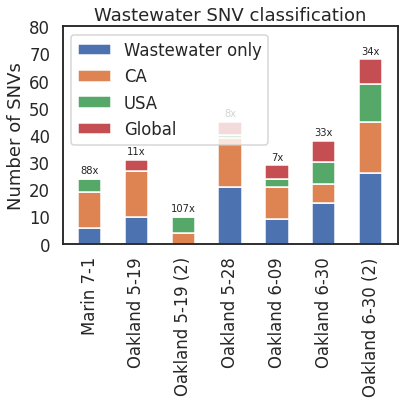

In [397]:
# Figure

WSdb2 = WSdb.query("allele_count == 2")
WSdb2 = WSdb.query("var_freq > 0.05")


table = defaultdict(list)
for sample, db in WSdb2.groupby('sample'):
    table['sample'].append(sample)
    table['SNVs'].append(len(db))
    table['InterPatient_SNVs'].append(len(db[db['Inter_present'] == True]))
    table['CA_Patient_SNVs'].append(len(db[db['CA_present'] == True]))
    table['USA_Patient_SNVs'].append(len(db[db['USA_present'] == True]))

    table['Recurrent_SNVs'].append(len(db[db['times_detected'] > 1]))
    
# db = WSdb.sort_values('key').drop_duplicates(subset=['key'])
# table['sample'].append('All')
# table['SNVs'].append(len(db))
# table['InterPatient_SNVs'].append(len(db[db['Inter_present'] == True]))
# table['Recurrent_SNVs'].append(len(db[db['times_detected'] > 1]))
    
fdb = pd.DataFrame(table)

fdb['name'] = fdb['sample'].map(Mdb.set_index('sample')['name'].to_dict())
fdb['coverage'] = fdb['sample'].map(Adb.set_index('sample')['coverage'].to_dict())

fdb = fdb.sort_values('name')

N = len(fdb)
uniq = [s-i for s, i in zip(fdb['SNVs'], fdb['InterPatient_SNVs'])]
ca_inter = [i for s, i in zip(fdb['SNVs'], fdb['CA_Patient_SNVs'])]

usa_inter = [i-j for s, i, j in zip(fdb['SNVs'], fdb['USA_Patient_SNVs'], fdb['CA_Patient_SNVs'])]
inter = [i-j for s, i, j in zip(fdb['SNVs'], fdb['InterPatient_SNVs'], fdb['USA_Patient_SNVs'])]

totals = [s for s, i in zip(fdb['SNVs'], fdb['InterPatient_SNVs'])]

covs = fdb['coverage'].tolist()
names = fdb['name'].tolist()
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

sns.set_style('white')

fig, ax = plt.subplots()
p1 = ax.bar(ind, uniq, width)
p2 = ax.bar(ind, ca_inter, width,
             bottom=uniq)
p3 = ax.bar(ind, usa_inter, width,
             bottom=[a+b for a,b in zip(uniq, ca_inter)])
p4 = ax.bar(ind, inter, width,
             bottom=[a+b+c for a,b,c in zip(uniq, ca_inter, usa_inter)])



# p1 = plt.bar(ind, uniq, width)
# p2 = plt.bar(ind, inter, width,
#              bottom=uniq)

for i, rect in enumerate(p2):
    ax.annotate('{0:.0f}x'.format(covs[i]),
               xy=(rect.get_x() + rect.get_width() / 2, totals[i]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


plt.ylabel('Number of SNVs')
plt.title('Wastewater SNV classification')
plt.xticks(ind, names, rotation=90)
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Wastewater only', 'CA', 'USA', 'Global'))

plt.gcf().savefig('Figure2a_v1.pdf', bbox_inches='tight')
plt.show()


## Figure 2b - Regional localization

In [458]:
# Calculate state-level p-values
table = defaultdict(list)
for sample, sdb in itertools.chain(WSdb.groupby('sample'), zip(['all'], [WSdb])):
    
    # Get the SNPs in this sample
    sample_snps = set(sdb.key.value_counts()[sdb.key.value_counts() > 0].index)
    
    # Iterate through states
    for div, CAdb in ISdb.groupby('location'):
        
        if ISdb[ISdb.location == div].shape[0] > 20:
        
            # Get the SNPs from this state
            state_snps = set((x[0], x[2]) for x in set.union(*CAdb['SNP_IDs'].tolist()) if x[2] != 'NA')

            # M = total number of sites
            # n = number of SNPs in CA
            # N = number of SNPs we see in wastewater
            total_possible_snps = IVdb.key.unique().shape[0]
            [M, n, N] = [total_possible_snps, len(state_snps), len(sample_snps)]

            # calculate the hypergeom distribution with those parameters
            rv = scipy.stats.hypergeom(M, n, N)

            # Calculate chance of seeing as many snps as we did
            p = rv.pmf(len(sample_snps.intersection(state_snps)))

            table['sample'].append(sample)
            table['division'].append(div)
            table['division_samples'].append(len(CAdb))
            table['percent_ww_in_division'].append(len(sample_snps.intersection(state_snps)) / len(sample_snps))
            table['num_sample_SNVs'].append(len(sample_snps))
            table['num_div_SNVs'].append(len(state_snps))
            table['p_value'].append(p)
                   
Ddb = pd.DataFrame(table)
Ddb.sort_values('p_value').head()

,sample,division,division_samples,percent_ww_in_division,num_sample_SNVs,num_div_SNVs,p_value
671,MR_7_1_MOS,Washington County OR,97,0.485714,35,194,3.193088e-26
597,MR_7_1_MOS,Dane County,608,0.628571,35,711,1.782993e-24
159,5_19_S_2,San Joaquin County,103,0.393939,33,106,2.412323e-22
646,MR_7_1_MOS,Santa Clara County,276,0.457143,35,268,6.747927e-22
9,5_19_S,Caddo Parish,124,0.625000,16,89,6.693201e-21


In [461]:
nor_cal_counties = ['Alameda County',
       'San Francisco',
       'San Joaquin County',
       'Santa Clara County',
       'Marin County',
       'Contra Costa County']

Ddb['neg_log'] = -np.log10(Ddb['p_value'])
Ddb2= Ddb

usa_ISdb = ISdb[ISdb.country == 'USA']
ca_ISdb = ISdb[ISdb.division == 'California']

Ddb2= Ddb2.assign(is_nor_cal="Global")
Ddb2.loc[Ddb2.division.isin(usa_ISdb['location']),'is_nor_cal'] = "USA"
Ddb2.loc[Ddb2.division.isin(ca_ISdb['location']),'is_nor_cal'] = "CA"

Ddb2.loc[Ddb2.division.isin(nor_cal_counties),'is_nor_cal'] = "NorCal"
Ddb2.loc[Ddb2.division == 'Alameda County','is_nor_cal'] = "Alameda"

Ddb2.loc[Ddb2.p_value > 0.05 / Ddb2.shape[0], "is_nor_cal"] = "n.s."

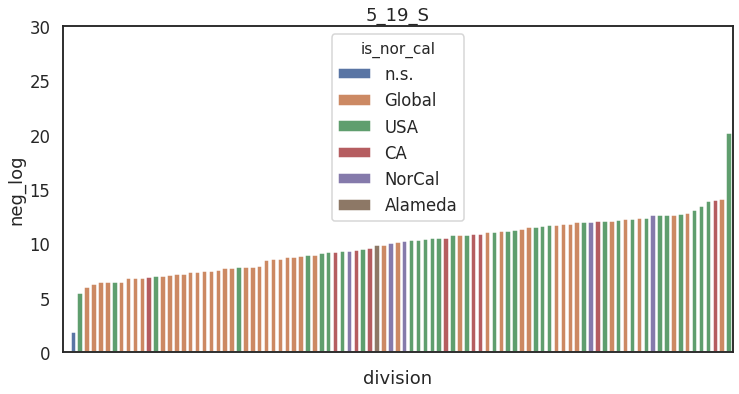

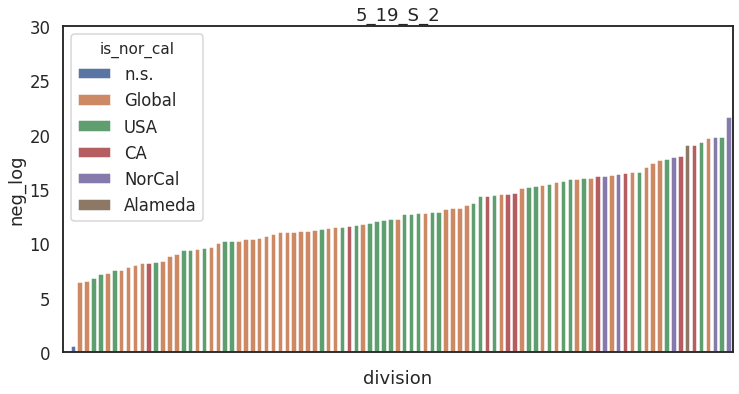

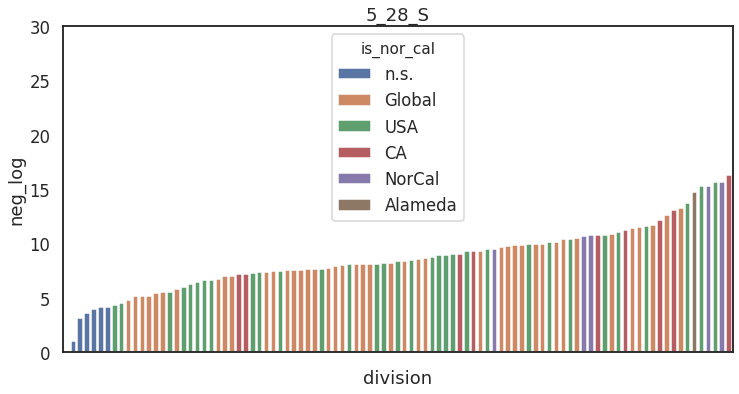

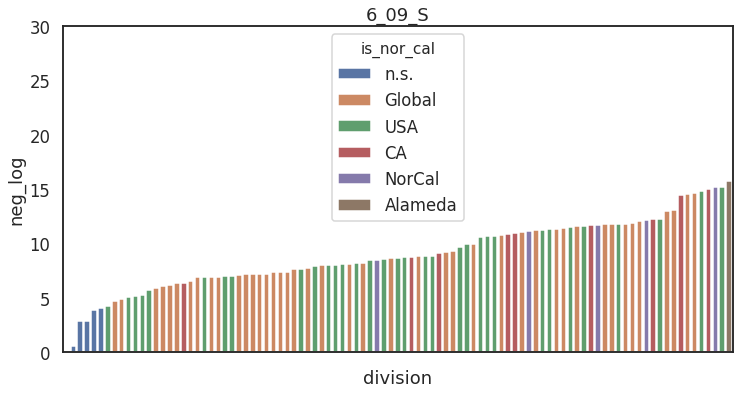

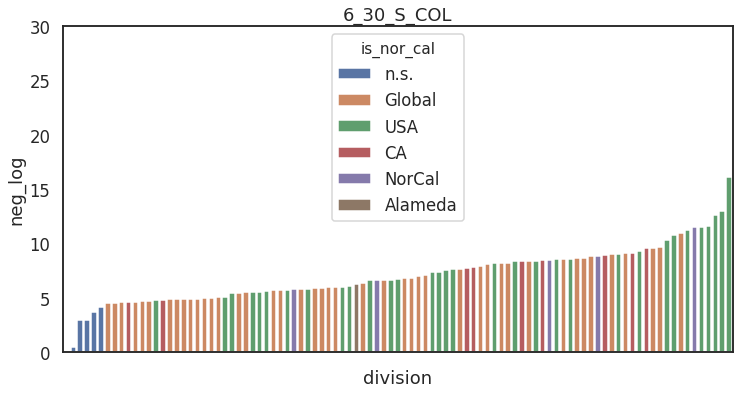

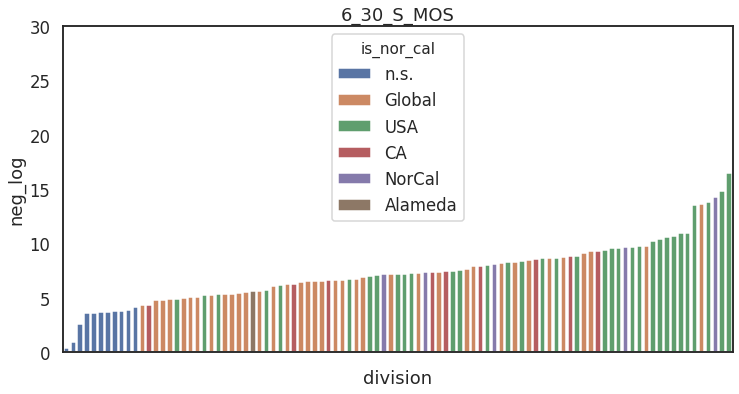

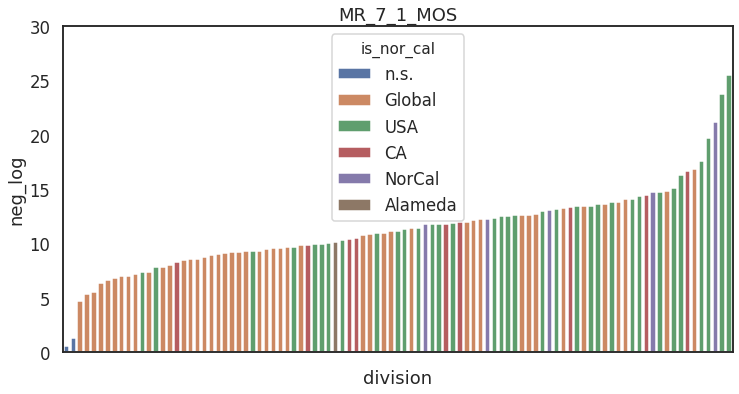

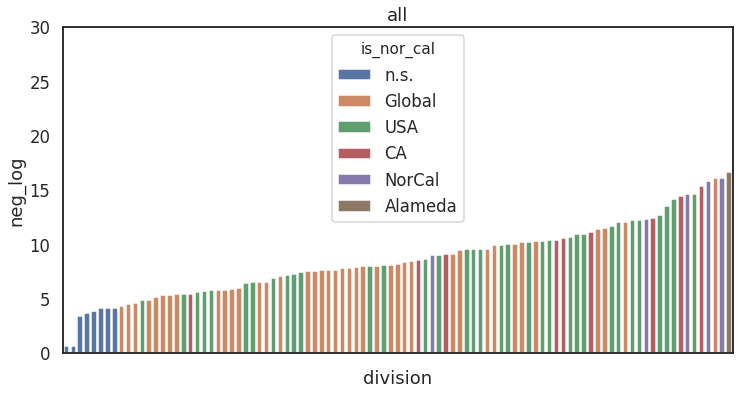

In [465]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("white")
sns.set_context("talk")
for sample in Ddb2['sample'].unique():
    sample_Ddb = Ddb2[Ddb2['sample'] == sample]
    g = sns.barplot(data=sample_Ddb.sort_values('neg_log'), x="division", y='neg_log', hue="is_nor_cal", hue_order = ['n.s.', 'Global', 'USA', 'CA', 'NorCal', 'Alameda'], ci=None, dodge=False)
    g.set_title(sample)
    g.set_ylim(0,30)
    g.set(xticklabels=[])
#     print(sample_Ddb.sort_values(""))
    plt.savefig(sample + ".regions.svg")
    plt.show()

## Figure 2c - Genomic localization

In [525]:
Mdb

,sample,location,date,name
0,5_19_S_2,Oakland,5-19,Oakland 5-19
1,5_19_S,Oakland,5-19,Oakland 5-19 (2)
2,5_28_S,Oakland,5-28,Oakland 5-28
3,6_09_S,Oakland,6-09,Oakland 6-09
4,6_30_S_COL,Oakland,6-30,Oakland 6-30
5,6_30_S_MOS,Oakland,6-30,Oakland 6-30 (2)
6,MR_7_1_MOS,Marin,7-1,Marin 7-1
7,SQ_7_1_MOS,SanQuentin,7-1,SanQuentin 7-1


In [481]:
# Establish dataframe
colors = sns.color_palette("Set3")
# WSdb2 = WSdb.query("allele_count == 2")
# WSdb2 = WSdb2.query("varFreq > 0.1")

Fdb = WSdb.copy()
Fdb['name'] = Fdb['sample'].map(Mdb.set_index('sample')['name'].to_dict())

ALL_snps = set((x[0], x[2]) for x in set.union(*ISdb['SNP_IDs'].tolist()) if x[2] != 'NA')
CA_snps = set((x[0], x[2]) for x in set.union(*ISdb[ISdb['division'] == 'California']['SNP_IDs'].tolist()) if x[2] != 'NA')
USA_snps = set((x[0], x[2]) for x in set.union(*ISdb[ISdb['country'] == 'USA']['SNP_IDs'].tolist()) if x[2] != 'NA')

Fdb['class'] = 'Wastewater only'
Fdb['class'] = ['Detected in the US' if snp in USA_snps else cl for snp, cl in zip(Fdb['key'], Fdb['class'])]
Fdb['class'] = ['Detected in CA' if snp in CA_snps else cl for snp, cl in zip(Fdb['key'], Fdb['class'])]

class2color = {'Wastewater only':colors[0], 'Detected Globally':colors[2], 'Detected in CA':colors[3], 'Detected in the US':colors[4]}
class2color = {cl:matplotlib.colors.to_hex(ca) for cl, ca in class2color.items()}

In [575]:
class2color = {'Wastewater only': '#cccccc',
 'Detected in CA': '#c83737',
 'Detected in the US': '#3771c8'}

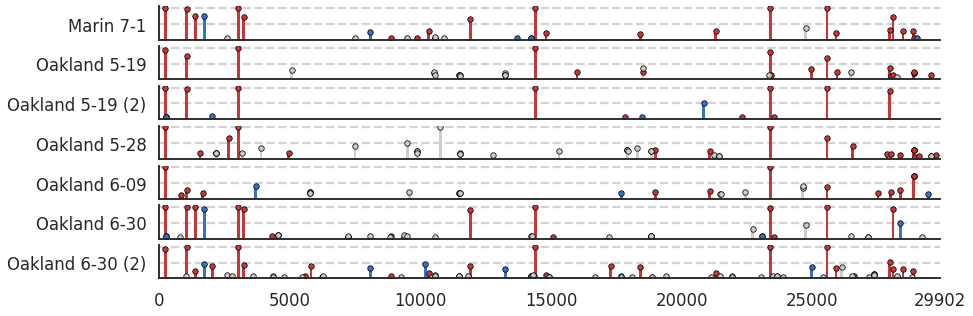

In [582]:
GENOME_LENGTH = 29902

# Establish subplots
sns.set_style('white')
rows = len(Fdb['name'].unique())
fig, axs = plt.subplots(
    rows, 1, figsize=(14, 5), sharex=True)#, gridspec_kw={"height_ratios": [4, 2, 2]}

# Plot
i = 0
#for sample, db in itertools.chain(Fdb.groupby('name'), zip(['All samples'], [WSdb])):
for sample, db in Fdb.groupby('name'):
    ax = axs[i]
    
    for cl, cdb in db.groupby('class'):
        c = [class2color[cl]]
        ax.bar(cdb['position'], cdb['key_freq'], width=100, color=c, label=cl, linewidth=0, zorder=1)

        ax.scatter(cdb['position'], cdb['key_freq'], c=c, edgecolors='black', s=30, marker='o',
                  alpha=1, lw=0.75, label=cl, zorder=2)
        
    
    ax.axhline(1, xmin=0, xmax=1, c='lightgrey', zorder=-1, ls='--')
    
    ax.axhline(0.5, xmin=0, xmax=1, c='lightgrey', zorder=-1, ls='--')
    ax.set_yticks([0.5])
    ax.set_yticklabels([sample])
    
    i += 1
    
# remove borders
for axes in axs: 
    #plt.setp(axes.spines.values(), visible=False)
    plt.setp(axes.spines['right'], visible = False)
    plt.setp(axes.spines['top'], visible = False)
        
# Re-do xticks
plt.xticks(np.concatenate([np.arange(0, 300001, 5000),[GENOME_LENGTH]]))
plt.xlim(0, GENOME_LENGTH)
    
# Labels
# plt.xlabel("Genomic position\n(reference genome EPI_ISL_402124)")
# l = axs[0].legend(loc="upper center", bbox_to_anchor=(0.5, 3),fancybox=True, shadow=True, ncol=3)
# l.set_zorder(20)

# plt.gcf().set_size_inches(8, 4)
plt.gcf().savefig('Figure2c_v3.pdf', bbox_inches='tight')
plt.show()

# Patient SNVs in wastewater - frequencies and recurrent examples

In [407]:
snp_location_status = []
for index, row in WSdb.iterrows():
    if row['CA_present']:
        snp_location_status.append("CA")
    elif row['USA_present']:
        snp_location_status.append("USA")
    elif row['Inter_present']:
        snp_location_status.append("Global")
    else:
        snp_location_status.append("Wastewater")

WSdb['snp_location_status'] = snp_location_status

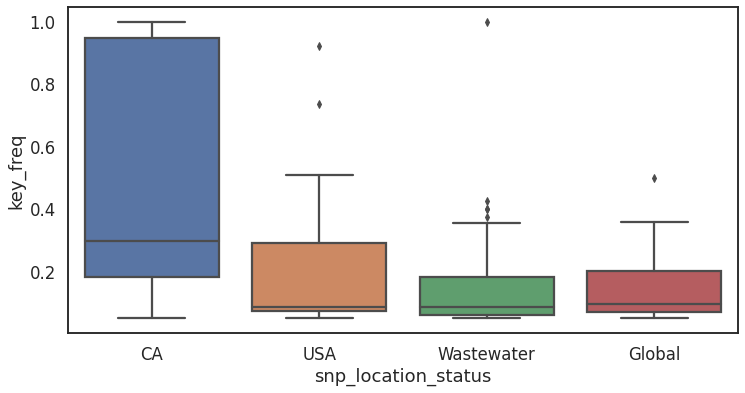

In [586]:
# WSdb2 = WSdb.query("allele_count == 2")

sns.boxplot(data=WSdb, x='snp_location_status', y="key_freq")
plt.savefig("snp_frequencies.svg")
plt.show()

In [592]:
CA_snps_abund = WSdb.query("snp_location_status == 'CA'")['key_freq']
Other_snps_abund = WSdb.query("snp_location_status != 'CA'")['key_freq']
from scipy import stats
print(np.mean(CA_snps_abund))
print(np.mean(Other_snps_abund))
print(stats.ttest_ind(CA_snps_abund,Other_snps_abund))

0.489706074135622
0.15339762556974548
Ttest_indResult(statistic=10.782341954279921, pvalue=4.994227563850766e-23)


In [409]:
WSdb2 = WSdb.query("allele_count == 2")
# WSdb2 = WSdb2.query("varFreq > 0.1")


fdb = WSdb2['key'].value_counts().to_frame()

counts_db = defaultdict(list)
types = ['CA', 'Wastewater', 'Global', 'USA']
for num_counts in fdb.key.unique():
    print(num_counts)
    count_data = WSdb[WSdb.key.isin(fdb[fdb.key == num_counts].index)].snp_location_status.value_counts()
    counts_db['samples'].append(num_counts)
    for t in types:
        if t in count_data:
            counts_db[t].append(count_data[t])
        else:
            counts_db[t].append(0)
counts_db = pd.DataFrame(counts_db)

4
3
2
1


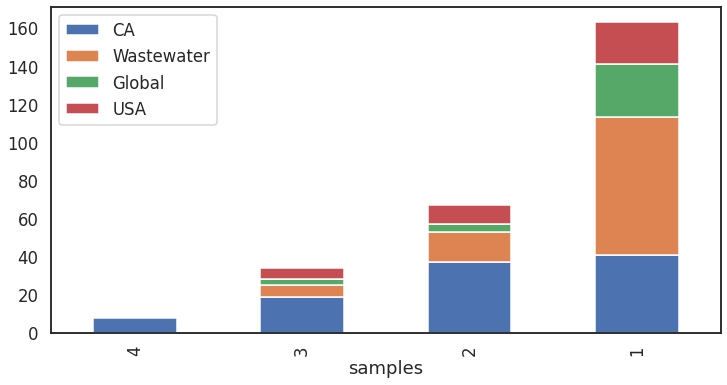

In [430]:
### Are recurrent snps found in the same genomes from elsewhere?
counts_db.plot.bar(x='samples', stacked=True)
plt.savefig("recurrent_snps.svg")

# Make timeline of SNVs in patients / wastewater

In [472]:
## Get SNPs in CA

recurrent = WSdb[WSdb['key'].isin(WSdb['key'].value_counts()[WSdb['key'].value_counts() > 1].index)]
CAdb = ISdb[ISdb.division == 'California']
CAdb.date = pd.to_datetime(CAdb.date)
x = []
y = []
i = 1
for snp in recurrent['key'].unique():
    if snp in list(IVdb.key):
        strains = list(IVdb[IVdb.key == snp]['strains'])[0]
        dates = CAdb[CAdb.strain.isin(strains)].date
        x = x + list(dates)
        y = y + list([snp]*len(dates))
        i += 1
        

In [473]:
## Get SNPs in USA
USAdb = ISdb[ISdb.country == 'USA']
USAdb.date = pd.to_datetime(USAdb.date)

x3 = []
y3 = []

for snp in recurrent['key'].unique():
    if snp not in CA_snps:
        if snp in USA_snps:
            strains = list(IVdb[IVdb.key == snp]['strains'])[0]
            dates = USAdb[USAdb.strain.isin(strains)].date
            x3 = x3 + list(dates)
            y3 = y3 + list([snp]*len(dates))
            print(str(snp) + "\t" + str(snp) + "\t" + str(len(dates)))

(1737, 'T')	(1737, 'T')	49
(8082, 'A')	(8082, 'A')	15
(14221, 'G')	(14221, 'G')	46
(14222, 'C')	(14222, 'C')	44
(17696, 'G')	(17696, 'G')	1
(263, 'G')	(263, 'G')	1
(265, 'T')	(265, 'T')	1


In [475]:
## Get SNPs in Wastewater

sample_dates = { '5_19_S_2': "2020-05-19", '5_28_S': "2020-05-28", 'SQ_7_1_MOS': "2020-07-01", '5_19_S': "2020-05-19", '6_30_S_COL': "2020-06-30",
       '6_09_S': "2020-06-09", 'MR_7_1_MOS': "2020-07-01", '6_30_S_MOS': "2020-06-30" }
sample_dates_list = []
for d in recurrent['sample']:
    sample_dates_list.append(sample_dates[d])
recurrent['date'] = pd.to_datetime(sample_dates_list)

x2 = []
y2 = []
for index, row in recurrent.iterrows():
    if row['key'] in key_dict:
        y2.append(row['key'])
        x2.append(row['date'])


<ipython-input-475-f0179539f842>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recurrent['date'] = pd.to_datetime(sample_dates_list)


In [ ]:
## create order to snps
## Get SNPs in CA

recurrent = WSdb[WSdb['key'].isin(WSdb['key'].value_counts()[WSdb['key'].value_counts() > 1].index)]
CAdb = ISdb[ISdb.division == 'California']
CAdb.date = pd.to_datetime(CAdb.date)
for snp in recurrent['key'].unique():
    if snp in list(IVdb.key):
        strains = list(IVdb[IVdb.key == snp]['strains'])[0]
        dates = CAdb[CAdb.strain.isin(strains)].date
        x = x + list(dates)
        y = y + list([snp]*len(dates))
        i += 1
        

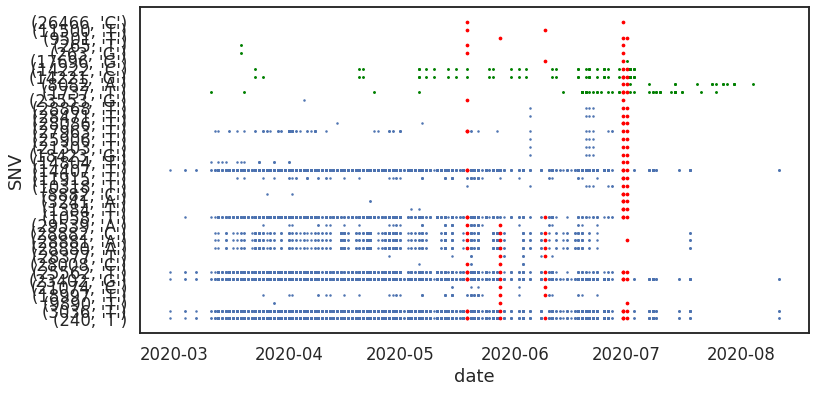

In [479]:
# Plot
plt.scatter(x, pd.Series(y).astype(str), s=1)
plt.xlabel('date')
plt.ylabel('SNV')

plt.scatter(x3, pd.Series(y3).astype(str), s=2, c='green')

plt.scatter(x2, pd.Series(y2).astype(str), s=5, c='red')

plt.savefig("snv_dates.svg")
plt.show()


# Identify recurrent USA SNP possible lineages

In [415]:
# ## Get recurrent USA snps
recurrent = WSdb[WSdb['key'].isin(WSdb['key'].value_counts()[WSdb['key'].value_counts() > 1].index)]
recurrent_usa = recurrent.query("snp_location_status == 'USA'")

# ## Get strains that have at least one recurrent USA SNP and besides that only SNPs observed in WW


In [416]:
# USA_snps.intersection(CA_snps)

In [417]:
recurrent_usa['key']

51      (1737, T)
56      (8082, A)
67     (14221, G)
68     (14222, C)
97     (17696, G)
118     (1737, T)
134     (8082, A)
148    (14221, G)
149    (14222, C)
160    (17696, G)
198      (263, G)
199      (265, T)
203     (1737, T)
222    (14221, G)
279      (263, G)
280      (265, T)
Name: key, dtype: object

In [418]:
usa_strain_set = list(IVdb[IVdb.key.isin(list(recurrent_usa['key']))]['strains'])

all_snps = []
for snp_set in usa_strain_set:
    all_snps = all_snps + list(snp_set)